#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션3

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 딥러닝 구조의 모델로 분류 모델 생성
    * 최소 4개 이상 모델링 수행
    * 각 모델별 최소 5회 반복수행해서 얻은 성능의 평균으로 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.
* 성능 가이드
    * Accuracy : 0.90 ~ 0.99

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input
from keras.backend import clear_session
from keras.optimizers import Adam

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 **'subject' 칼럼은 불필요** 하므로 삭제합니다.

#### 1) 데이터로딩

In [ ]:
file1 = 'data01_train.csv'
file2 = 'data01_test.csv'
file3 = 'features.csv'

In [ ]:
data = pd.read_csv(path + file1)
test = pd.read_csv(path + file2)
features = pd.read_csv(path + file3)

In [ ]:
# 불필요한 칼럼 삭제
data.drop('subject', axis=1, inplace=True)
test.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [ ]:
#전체 데이터의 행,열 개수 확인
data.shape

(5881, 562)

In [ ]:
#전체 데이터의 상위 5개 행 확인
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [ ]:
#전체 데이터의 수치형 변수 분포 확인
data.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [ ]:
#전체 데이터의 모든 변수 확인
data.columns

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [ ]:
target = 'Activity'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

### (2) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 100)

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [ ]:
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [ ]:
x_train  = x_train_scaled
x_val = x_val_scaled

### (4) Y 전처리
* integer encoding : LabelEncoder
* (필요시) one-hot encoding

In [ ]:
# 정수 인코딩 변환
int_Encoder = LabelEncoder()
y_train= int_Encoder.fit_transform(y_train)
y_val = int_Encoder.transform(y_val)


In [ ]:
# 기존 레이블 저장
y_labels = int_Encoder.classes_
y_labels

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

## **3. 기본 모델링**



* 세부 요구사항
    - 모델1 : Base line 모델
        * Hidden Layer 없이 모델 생성
    - 모델2 : 복잡한 모델 생성
        * 최소 5개 이상의 은닉층을 추가한 모델
    - 모델3 ~ n : 튜닝 모델
        * 학습률, epoch 등 조정
        * 모델2에 과적합을 방지하기 위한 규제 기법 추가
        * Accuracy 최대화 시키는 모델 생성하기
    - 각 모델은 최소 5번 반복수행해서 얻은 성능의 평균값을 기록

### (1) 모델1

In [ ]:
n_features = x_train.shape[1]

In [ ]:
# 모델 설계
model1 = Sequential([Input(shape=(n_features,)),
                     Dense(6, input_shape = [n_features, ], activation = 'softmax')])
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_69 (Dense)                │ (None, 6)              │         3,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,372 (13.17 KB)

 Trainable params: 3,372 (13.17 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
model1.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy')
history = model1.fit(x_train, y_train, epochs = 50, validation_split=0.2).history

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.8344 - val_loss: 0.3039
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2892 - val_loss: 0.2382
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1937 - val_loss: 0.1669
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1615 - val_loss: 0.1455
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1419 - val_loss: 0.1461
Epoch 6/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1486 - val_loss: 0.1237
Epoch 7/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1136 - val_loss: 0.1232
Epoch 8/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1423 - val_loss: 0.1053
Epoch 9/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0894 - val_loss: 0.1055
Epoch 10/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0895 - val_loss: 0.1700
Epoch 11/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0879 - val_loss: 0.0991
Epoch 12/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

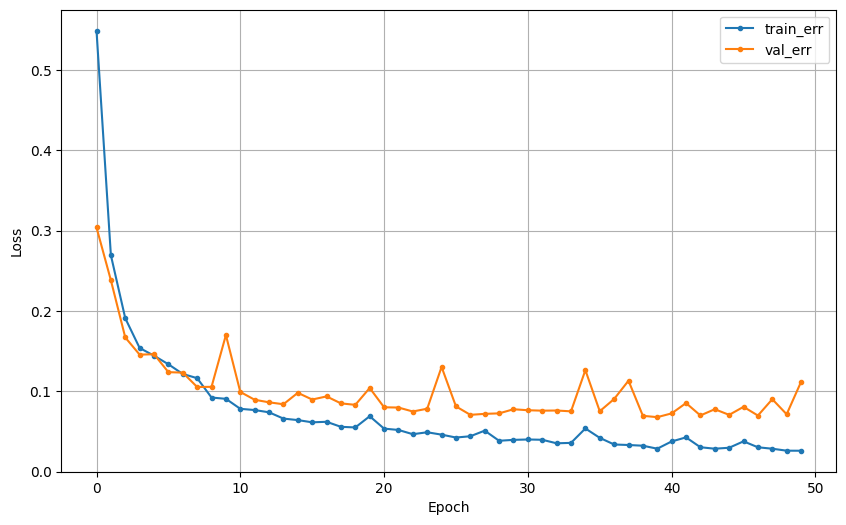

In [ ]:
# 학습곡선
dl_history_plot(history)

In [ ]:
# 예측 및 평가
pred1 = model1.predict(x_val)
pred1 = np.argmax(pred1, axis = 1)

print('accuracy :',accuracy_score(y_val, pred1))
print('='*60)
print(confusion_matrix(y_val, pred1))
print('='*60)
print(classification_report(y_val, pred1, target_names = y_labels))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
accuracy : 0.9668649107901445
[[227   0   0   0   0   0]
 [  0 184  34   0   0   1]
 [  0   1 218   0   0   0]
 [  0   0   0 197   1   0]
 [  0   0   0   0 138   1]
 [  0   0   0   1   0 174]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       227
           SITTING       0.99      0.84      0.91       219
          STANDING       0.87      1.00      0.93       219
           WALKING       0.99      0.99      0.99       198
WALKING_DOWNSTAIRS       0.99      0.99      0.99       139
  WALKING_UPSTAIRS       0.99      0.99      0.99       175

          accuracy                           0.97      1177
         macro avg       0.97      0.97      0.97      1177
      weighted avg       0.97      0.97      0.97      1177



* 반복 수행을 위한 코드(옵션)
--> 모델1번 최소 5번 반복수행하고 얻은 평균/표준편차 계산하는 방법

In [ ]:
def train_model1(x_train, y_train, x_val, y_val):
    model1 = Sequential([Dense(6, input_shape = [x_train.shape[1], ], activation = 'softmax')])
    model1.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy')
    model1.fit(x_train, y_train, epochs = 50, verbose=0)
    pred1 = model1.predict(x_val)
    pred1 = np.argmax(pred1, axis = 1)
    return accuracy_score(y_val, pred1)


In [ ]:
result1 = []
for i in range(5):
    result1.append(train_model1(x_train, y_train, x_val, y_val))

print(result1)
print(np.mean(result1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[0.9694137638062872, 0.9855564995751912, 0.9847068819031436, 0.9804587935429057, 0.9762107051826678]
0.9792693288020391


### (2) 모델2

In [ ]:
# 모델 설계
model2 = Sequential([Dense(512, input_shape = [n_features, ], activation = 'relu'),
                     Dense(512, activation = 'relu'),
                     Dense(256, activation = 'relu'),
                     Dense(256, activation = 'relu'),
                     Dense(128, activation = 'relu'),
                     Dense(128, activation = 'relu'),
                     Dense(64, activation = 'relu'),
                     Dense(64, activation = 'relu'),
                     Dense(32, activation = 'relu'),
                     Dense(32, activation = 'relu'),
                     Dense(6, activation = 'softmax')])
model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 512)            │       287,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812,678 (3.10 MB)

 Trainable params: 812,678 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
model2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')
history = model2.fit(x_train, y_train, epochs = 200, validation_split=0.2).history

Epoch 1/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.2113 - val_loss: 0.5842
Epoch 2/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5836 - val_loss: 0.7402
Epoch 3/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5067 - val_loss: 0.2788
Epoch 4/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2793 - val_loss: 0.2416
Epoch 5/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2107 - val_loss: 0.2565
Epoch 6/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2405 - val_loss: 0.1809
Epoch 7/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1731 - val_loss: 0.1650
Epoch 8/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1502 - val_loss: 0.1335
Epoch 9/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1327 - val_loss: 0.1374
Epoch 10/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1027 - val_loss: 0.0924
Epoch 11/200
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0762 - val_loss: 0.0887
Epoch 12/200
118/118 ━━━━━━━━━━━━━━━━━━━

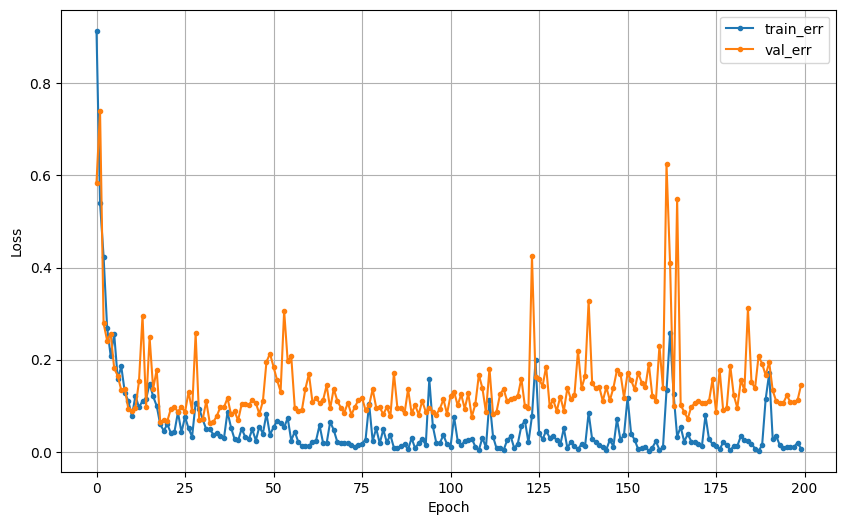

In [ ]:
# 학습곡선
dl_history_plot(history)

In [ ]:
# 예측 및 평가
pred2 = model2.predict(x_val)
pred2 = np.argmax(pred2, axis = 1)

print('accuracy :',accuracy_score(y_val, pred2))
print('='*60)
print(confusion_matrix(y_val, pred2))
print('='*60)
print(classification_report(y_val, pred2, target_names = y_labels))

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
accuracy : 0.9796091758708582
[[227   0   0   0   0   0]
 [  0 212   6   0   0   1]
 [  0  12 207   0   0   0]
 [  0   0   0 197   1   0]
 [  0   0   0   1 136   2]
 [  0   0   0   1   0 174]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       227
           SITTING       0.95      0.97      0.96       219
          STANDING       0.97      0.95      0.96       219
           WALKING       0.99      0.99      0.99       198
WALKING_DOWNSTAIRS       0.99      0.98      0.99       139
  WALKING_UPSTAIRS       0.98      0.99      0.99       175

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



### (3) 모델3

In [ ]:
# 모델 설계
do_rate = 0.1

model3 = Sequential([Dense(512, input_shape = [n_features, ], activation = 'relu'),
                     Dropout(do_rate),
                     Dense(512, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(256, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(256, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(128, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(128, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(64, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(64, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(32, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(32, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(6, activation = 'softmax')])
model3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_86 (Dense)                │ (None, 512)            │       287,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812,678 (3.10 MB)

 Trainable params: 812,678 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy')
history = model3.fit(x_train, y_train, epochs = 100, validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 1.7337 - val_loss: 1.2174
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3476 - val_loss: 0.8693
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0309 - val_loss: 0.6765
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7980 - val_loss: 0.5154
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6859 - val_loss: 0.3652
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5497 - val_loss: 0.3065
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4751 - val_loss: 0.3212
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.4151 - val_loss: 0.2457
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3620 - val_loss: 0.2428
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3415 - val_loss: 0.1921
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2883 - val_loss: 0.1701
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━━━

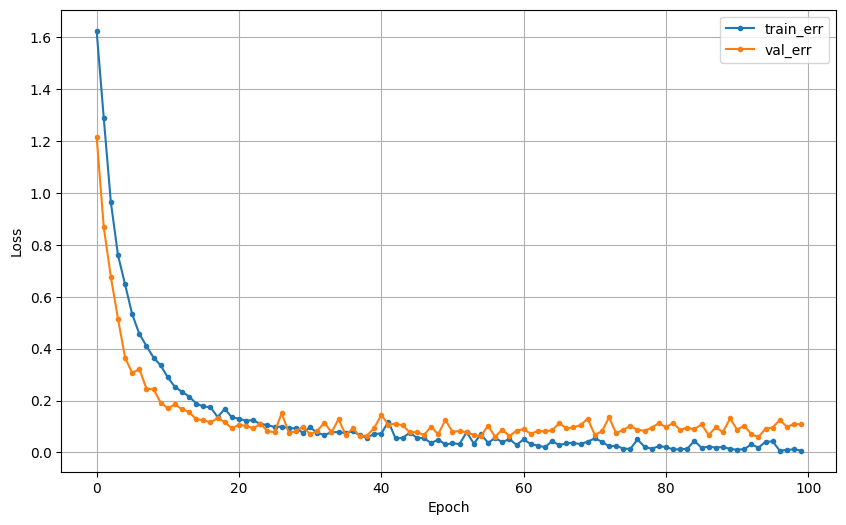

In [ ]:
# 학습곡선
dl_history_plot(history)

In [ ]:
# 예측 및 평가
pred3 = model3.predict(x_val)
pred3 = np.argmax(pred3, axis = 1)

print('accuracy :',accuracy_score(y_val, pred3))
print('='*60)
print(confusion_matrix(y_val, pred3))
print('='*60)
print(classification_report(y_val, pred3, target_names = y_labels))

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
accuracy : 0.9813084112149533
[[227   0   0   0   0   0]
 [  0 209   9   0   0   1]
 [  0   8 211   0   0   0]
 [  0   0   0 197   1   0]
 [  0   0   0   0 138   1]
 [  0   0   0   2   0 173]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       227
           SITTING       0.96      0.95      0.96       219
          STANDING       0.96      0.96      0.96       219
           WALKING       0.99      0.99      0.99       198
WALKING_DOWNSTAIRS       0.99      0.99      0.99       139
  WALKING_UPSTAIRS       0.99      0.99      0.99       175

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



### (4) 모델4

In [ ]:
# 모델 설계
do_rate = 0.2

model4 = Sequential([Dense(512, input_shape = [n_features, ], activation = 'relu'),
                     Dropout(do_rate),
                     Dense(512, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(256, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(256, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(128, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(128, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(64, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(64, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(32, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(32, activation = 'relu'),
                     Dropout(do_rate),
                     Dense(6, activation = 'softmax')])
model4.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_97 (Dense)                │ (None, 512)            │       287,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 812,678 (3.10 MB)

 Trainable params: 812,678 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 컴파일 및 학습
model4.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy')
history = model4.fit(x_train, y_train, epochs = 100, validation_split=0.2).history

Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - loss: 1.7787 - val_loss: 1.5135
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5660 - val_loss: 1.3586
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4346 - val_loss: 1.0571
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2025 - val_loss: 0.8627
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0582 - val_loss: 0.7879
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9836 - val_loss: 0.7638
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8989 - val_loss: 0.7276
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8658 - val_loss: 0.6812
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8284 - val_loss: 0.6142
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7465 - val_loss: 0.5723
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7181 - val_loss: 0.5176
Epoch 12/100
118/118 ━━━━━━━━━━━━━━━━━━

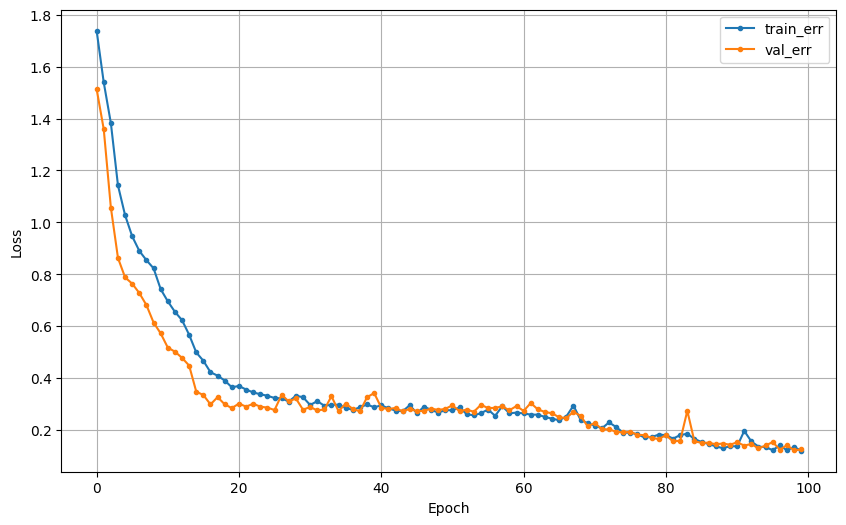

In [ ]:
# 학습곡선
dl_history_plot(history)

In [ ]:
# 예측 및 평가
pred4 = model4.predict(x_val)
pred4 = np.argmax(pred4, axis = 1)

print('accuracy :',accuracy_score(y_val, pred4))
print('='*60)
print(confusion_matrix(y_val, pred4))
print('='*60)
print(classification_report(y_val, pred4, target_names = y_labels))

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
accuracy : 0.9745114698385726
[[227   0   0   0   0   0]
 [  0 205  13   0   0   1]
 [  0  13 206   0   0   0]
 [  0   0   0 195   3   0]
 [  0   0   0   0 139   0]
 [  0   0   0   0   0 175]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       227
           SITTING       0.94      0.94      0.94       219
          STANDING       0.94      0.94      0.94       219
           WALKING       1.00      0.98      0.99       198
WALKING_DOWNSTAIRS       0.98      1.00      0.99       139
  WALKING_UPSTAIRS       0.99      1.00      1.00       175

          accuracy                           0.97      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.97      0.97      0.97      1177



## 4.성능비교

* 세부 요구사항
    - test 데이터에 대한 전처리
    - 각 모델에 대해서 test 데이터로 성능 측정

In [ ]:
#전체 데이터 불러오기
file2 = "data01_test.csv"
newdata = pd.read_csv(path+file2)

# subject 삭제
newdata.drop('subject', axis=1, inplace=True)

# x, y 분할
new_x = newdata.drop(['Activity'], axis = 1)
new_y = newdata.Activity

# x : 스케일링 적용
new_x = scaler.transform(new_x)

# y : 정수인코딩 적용
new_y = int_Encoder.transform(new_y)

In [ ]:
# test 데이터에 대한 성능 측정
models = [model1, model2, model3,model4]
for i, model in enumerate(models):
  pred = model.predict(new_x)
  pred = np.argmax(pred, axis = 1)
  print(f'model{i+1}, accuracy : {accuracy_score(new_y, pred)}')

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
model1, accuracy : 0.9571719918422842
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
model2, accuracy : 0.9796057104010877
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
model3, accuracy : 0.9864038069340585
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
model4, accuracy : 0.9694085656016316
